<a href="https://colab.research.google.com/github/pcashman21/feral-cat-census/blob/main/src/notebooks/cluster_by_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook performs the following steps:


1.   Run YOLO v8 on all raw images to get cropped-image files based on detecting either entire cats or just cat faces/heads.
2.   If necessary, run a step to check that all the cropped-image files are usable.  In the case of cat faces, we assume they all are.  (Actually, we can filter out those that aren't based on file name.) In the case of full cat bodies, run each image through a model that can determine usability.
3.   Run a transformer to compute a dense vector representation of all the cropped images, and compute a similarity score for each pair of images.
4.   Assign cluster IDs first to all the images that are above a given similarity score threshold, and then to all remaining unclustered images (each of which becomes a singleton cluster).  The number of clusters is the estimated number of distinct cats.



In [1]:
# for loading/processing the images
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input

# models
from keras.models import Model, load_model
from keras import layers

# for everything else
from google.colab import drive
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pandas as pd
import tensorflow as tf
import cv2
import math

# YOLO
!pip install ultralytics
from ultralytics import YOLO

# transformer
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer, util


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.5/644.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.0 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=3c34d152319deb8423d0594e912b28a46eb434f314fe84d2bc2639609386f989
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence

In [19]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Name of object class for YOLO to detect ('cat' for entire cat in any pose, 'cat-face' for just cat faces/heads)
class_to_detect = 'cat' # 'cat' for whole cat, 'cat-face' for just faces

# Path to trained YOLO model for image detection (cats or cat faces)
path_to_best_cat_detector = ''
if class_to_detect == 'cat':
  path_to_best_cat_detector = '/content/gdrive/My Drive/Cat images/feral-cat-census.v1i.yolov8/runs/detect/train/weights/best.pt'
elif class_to_detect == 'cat-face':
  path_to_best_cat_detector = '/content/gdrive/My Drive/Cat images/feral-cat-faces.v1i.yolov8/runs/detect/train/weights/best.pt'

cat_detector_model = YOLO(path_to_best_cat_detector)  # load the cat (or cat face) detector model

# Path to trained model for detecting usable images.  If set to '', then we are simply accepting all images
path_to_usable_image_selector_model = '' #  '/content/gdrive/My Drive/Cat images/models/select_usable_images.keras'
if path_to_usable_image_selector_model == '':
  usable_image_selector_model = None
else:
  usable_image_selector_model = load_model(path_to_usable_image_selector_model) # load usable/unsuable image selector model


Load the zip file of cat images into the working storage of the notebook by clicking the folder in the left nav, and then the upload symbol in the menu bar.  Adjust the `path_to_images` variable to point to the unzipped folder.

In [ ]:
# Path to raw images of cats (BE SURE TO UPLOAD AND UNZIP)
path_to_images = '/content/shb_unique'
zip_file_name = path_to_images +'.zip'


import zipfile
!unzip $zip_file_name


Archive:  /content/shb_unique.zip
  inflating: shb_unique/Copy of IMG_3784.jpeg  
  inflating: shb_unique/Copy of IMG_1292.jpeg  
  inflating: shb_unique/Copy of IMG_4033.jpeg  
  inflating: shb_unique/Copy of IMG_4034.jpeg  
  inflating: shb_unique/Copy of IMG_4065.jpeg  
  inflating: shb_unique/Copy of IMG_1378.jpeg  
  inflating: shb_unique/Copy of IMG_4217.jpeg  
  inflating: shb_unique/Copy of IMG_3935.jpeg  
  inflating: shb_unique/Copy of IMG_4033(1).jpeg  
  inflating: shb_unique/Copy of IMG_1331.jpeg  
  inflating: shb_unique/Copy of IMG_4071.jpeg  
  inflating: shb_unique/Copy of IMG_4047.jpeg  
  inflating: shb_unique/Copy of IMG_3932.jpeg  
  inflating: shb_unique/Copy of IMG_1302.jpeg  
  inflating: shb_unique/Copy of IMG_2185.jpeg  
  inflating: shb_unique/Copy of IMG_3927.jpeg  
  inflating: shb_unique/Copy of IMG_4330.jpeg  
  inflating: shb_unique/Copy of IMG_2190.jpeg  
  inflating: shb_unique/Copy of IMG_3921.jpeg  
  inflating: shb_unique/Copy of IMG_1710.jpeg  
  i

In [ ]:
path_to_cropped_images = '/content/runs/detect/cropped_images'
path_to_cropped_and_classified_images = os.path.join(path_to_cropped_images, class_to_detect)

In [ ]:
test_case_images = []
df = pd.DataFrame(columns=['orig_image_filename', 'cropped_image_filename', 'cluster_id'])

# Read all image files
with os.scandir(path_to_images) as files:
  for file in files:
    last_component = file.name.split('.')[-1]
    if last_component == 'jpg' or last_component == 'jpeg':
      test_case_images.append(file.name)

# Run the YOLOv8 model (the cat detector) and get a YOLO Results object for
# each file named in the df
# https://docs.ultralytics.com/modes/predict/#working-with-results
root_filename = 'img'
root_filename_count = 0
for test_case in test_case_images:
  results = cat_detector_model.predict(source=os.path.join(path_to_images, test_case))
  # Extract the image sub areas and save them as files
  for r in results:
    cropped_image_file_name = root_filename + str(root_filename_count) + '.jpg'
    df = pd.concat([df, pd.DataFrame([{'orig_image_filename': test_case, 'cropped_image_filename': cropped_image_file_name, 'cluster_id': -1 }], index=[len(df)])],  axis=0)
    r.save_crop(save_dir=path_to_cropped_images, file_name=cropped_image_file_name)
    root_filename_count += 1

if usable_image_selector_model is not None:

  # The cat detector isn't perfect.  It finds cats where there are none, and
  # doesn't always split up multiple cats into individual images.  So run the
  # YOLOv8 resulting cropped image files through the usable/unusable model
  # and delete any files that don't have a single cat.

  # We're reading raw images from the cropped image files, so transform them
  # by normalizing the pixels and resizing the image
  transformer_nn = tf.keras.Sequential([
        layers.Resizing(244,244),
        layers.Rescaling(1./255)])

  # Compile a list of all the cropped images
  cropped_image_files = []
  unusable_images_count = 0
  with os.scandir(path_to_cropped_and_classified_images) as files:
    for file in files:
      # YOLO will save cropped images which are unusable.  These have YOLO-generated names
      # that don't appear in the df.  If we are given such a file to process, ignore it.
      if file.name not in df['cropped_image_filename'].values:
        continue

      image = imread(os.path.join(path_to_cropped_and_classified_images, file.name)) # Get the cropped image
      # Transform the image by resizing and rescaling
      image_resized = transformer_nn(image)
      # Convert tensor to numpy array
      image_resized = image_resized.numpy()
      # Turn the image into a batch of 1
      image_batch = np.expand_dims(image_resized, axis=0)
      # Predict the batch outcome
      is_usable = usable_image_selector_model.predict(image_batch)[0] > .5
      if is_usable:
        cropped_image_files.append(file.name)
      else:
        print('Unusable image: {}'.format(file.name))
        plt.imshow(image_resized)
        plt.show()
        unusable_images_count += 1
        df = df.drop(df.index[df['cropped_image_filename'] == file.name], axis=0)
  print('Total of {} unusable images and {} usable images'.format(unusable_images_count, len(cropped_image_files)))
else:
  print('Total of {} usable images'.format(len(df)))



image 1/1 /content/shb_unique/Copy of IMG_1292.jpeg: 640x640 (no detections), 25.3ms
Speed: 14.0ms preprocess, 25.3ms inference, 21.9ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/shb_unique/Copy of IMG_4217.jpeg: 480x640 1 cat, 66.7ms
Speed: 2.9ms preprocess, 66.7ms inference, 2211.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/shb_unique/Copy of IMG_3935.jpeg: 480x640 1 cat, 6.5ms
Speed: 4.0ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/shb_unique/Copy of IMG_3921.jpeg: 640x480 2 cats, 53.0ms
Speed: 4.1ms preprocess, 53.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/shb_unique/Copy of IMG_1302.jpeg: 480x640 2 cats, 7.0ms
Speed: 2.7ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/shb_unique/Copy of IMG_2185.jpeg: 480x640 1 cat, 6.3ms
Speed

Total of 23 usable images


In [ ]:
# TODO: Why can files be missing?
for file in df['cropped_image_filename'].values:
    if not os.path.isfile(os.path.join(path_to_cropped_and_classified_images, file)):
      print('Missing file: {}'.format(file))
      df = df.drop(df.index[df['cropped_image_filename'] == file], axis=0)






Missing file: img0.jpg
Missing file: img7.jpg
Missing file: img16.jpg


In [ ]:
len(df)

20

In [ ]:
# Load the OpenAI CLIP Model
model = SentenceTransformer('clip-ViT-B-32')

# Next we compute the embeddings
image_names = df['cropped_image_filename'].values # All the names of YOLO-produced cropped images
encoded_image = model.encode([Image.open(os.path.join(path_to_cropped_and_classified_images, filepath)) for filepath in image_names], batch_size=128, convert_to_tensor=True, show_progress_bar=True)

# Now we run the clustering algorithm. This function compares images against
# all other images and returns a list with the pairs that have the highest
# cosine similarity score
processed_images = util.paraphrase_mining_embeddings(encoded_image)
df_processed_images = pd.DataFrame(processed_images, columns=['score', 'image_id1', 'image_id2'])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
CLUSTER_THRESHOLD = 0.95
next_cluster_id = 1
df['cluster_id'] = -1


def does_pair_form_cluster(row):
    if row['score'] >= CLUSTER_THRESHOLD:
        return True
    else:
        return False


def get_cluster_image_names(row):
    return [image_names[row['image_id1']], image_names[row['image_id2']]]


def assign_cluster_id(row):
  global next_cluster_id
  if row['is_cluster']:
      file1, file2 = get_cluster_image_names(row)
      idx1 = df[df['cropped_image_filename'] == file1].index
      idx2 = df[df['cropped_image_filename'] == file2].index
      if len(idx1) == 1 and len(idx2) == 1:
        if int(df['cluster_id'].loc[idx1]) > -1:
          df['cluster_id'].loc[idx2] = int(df['cluster_id'].loc[idx1])
        elif int(df['cluster_id'].loc[idx2]) > -1:
          df['cluster_id'].loc[idx1] = int(df['cluster_id'].loc[idx2])
        else:
          df['cluster_id'].loc[idx1] = int(next_cluster_id)
          df['cluster_id'].loc[idx2] = int(next_cluster_id)
          next_cluster_id += 1

def assign_unclustered_images(row):
  global next_cluster_id
  if row['cluster_id'] == -1:
      # row['cluster_id'] = next_cluster_id
      next_cluster_id += 1
      return next_cluster_id - 1
  else:
      return row['cluster_id']


def plot_cluster(cluster_id):
  cluster_filenames = df[df['cluster_id'] == cluster_id]
  file_count = len(cluster_filenames)
  columns = 2
  rows = math.ceil(file_count / columns)
  fig = plt.figure(figsize=(10,8))
  for i in range(file_count):
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.imshow(imread(os.path.join(path_to_cropped_and_classified_images, cluster_filenames['cropped_image_filename'].iloc[i])))
    plt.axis('off')
    # cat_name is oriented to TinyKittens format names
    cat_name = cluster_filenames['orig_image_filename'].iloc[i].split('.')[0].split('_')[0]
    plt.title('Index {}\n{}'.format(cluster_filenames.index[i],cat_name))
  plt.show()



In [ ]:
# Determine which image pairs are close enough to belong to the same cluster.  If a row in
# df_processed_images can be clustered, mark it as true.
df_processed_images['is_cluster'] = df_processed_images.apply(does_pair_form_cluster, axis=1)

# For all the clusterable pairs, assign cluster IDs in df (NOT df_processed_images)
df_processed_images.apply(assign_cluster_id, axis=1)

# Finally, assign cluster IDs to all images which have not been put into a cluster already.
# These are singleton images.
df['cluster_id'] = df.apply(assign_unclustered_images, axis=1)

# How many distinct clusters (cats) are there?
df['cluster_id'].max()

4

In [ ]:
df['cluster_id'].value_counts()


1    2
2    1
3    1
4    1
Name: cluster_id, dtype: int64

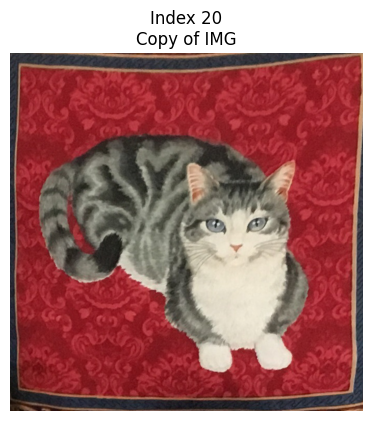

In [ ]:
plot_cluster(4)

In [ ]:
l

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [3]:
# We're reading raw images from the cropped image files, so transform them
  # by normalizing the pixels and resizing the image
transformer1_nn = tf.keras.Sequential([
        layers.Resizing(244,244),
        layers.Rescaling(1./255)])

In [4]:
import zipfile
!unzip /content/cropped_images-cat.zip

Archive:  /content/cropped_images-cat.zip
  inflating: cropped_images/img142.jpg  
  inflating: cropped_images/img2.jpg  
  inflating: cropped_images/img18.jpg  
  inflating: cropped_images/img93.jpg  
  inflating: cropped_images/img14.jpg  
  inflating: cropped_images/img11.jpg  
  inflating: cropped_images/img92.jpg  
  inflating: cropped_images/img17.jpg  
  inflating: cropped_images/img143.jpg  
  inflating: cropped_images/img9.jpg  
  inflating: cropped_images/img4.jpg  
  inflating: cropped_images/img1.jpg  
  inflating: cropped_images/img172.jpg  
  inflating: cropped_images/img13.jpg  
  inflating: cropped_images/img20.jpg  
  inflating: cropped_images/img42.jpg  
  inflating: cropped_images/img21.jpg  
  inflating: cropped_images/img212.jpg  
  inflating: cropped_images/img15.jpg  
  inflating: cropped_images/img10.jpg  
  inflating: cropped_images/img222.jpg  
  inflating: cropped_images/img123.jpg  
  inflating: cropped_images/img8.jpg  
  inflating: cropped_images/img5.jpg 

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt


In [36]:
df = pd.DataFrame([
    [1, 'Captain'],
    [2, 'Tavvy'],
    [3, 'Captain'],
    [4, 'Unknown'],
    [5, 'Captain_Bebop'],
    [6, 'Captain_Bebop'],
    [8, 'Bebop'],
    [9, 'Captain'],
    [10, 'Captain'],
    [11, 'Zoodles'],
    [12, 'Captain'],
    [13, 'Captain'],
    [14, 'Captain'],
    [15, 'Bebop'],
    [17, 'Zoodles'],
    [18, 'Pillow'],
    [19, 'Captain'],
    [20, 'Zoodles'],
    [21, 'Bebop'],
    [22, 'Captain'],
    [32, 'Captain'],
    [42, 'Zoodles'],
    [92, 'Tavvy'],
    [122, 'Captain'],
    [123, 'Captain'],
    [142, 'Tavvy'],
    [143, 'Tavvy'],
    [172, 'Tavvy'],
    [202, 'Zoodles'],
    [212, 'Bebop_Zoodles'],
    [222, 'Captain']
    ], columns= ['cropped_file_number', 'cat'])
df.set_index('cropped_file_number', inplace=True)

df.fillna(0)
for i in df.index:
  for j in df.index:
    im1 = tf.image.decode_image(tf.io.read_file(os.path.join('/content/cropped_images/', 'img' + str(i) + '.jpg')))
    im2 = tf.image.decode_image(tf.io.read_file(os.path.join('/content/cropped_images/', 'img' + str(j) + '.jpg')))
    im1_resized = transformer1_nn(im1)
    im2_resized = transformer1_nn(im2)
    im1_batch = tf.expand_dims(im1_resized, axis=0)
    im2_batch = tf.expand_dims(im2_resized, axis=0)
    ssim = tf.image.ssim(im1_batch, im2_batch, max_val=255, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
    df.loc[i,j] = ssim[0].numpy()
df







,cat,1,2,3,4,5,6,8,9,10,...,42,92,122,123,142,143,172,202,212,222
cropped_file_number,,,,,,,,,,,,,,,,,,,,,
1,Captain,1.000000,0.971927,0.985220,0.974401,0.968607,0.986914,0.980127,0.977608,0.985509,...,0.975961,0.971709,0.982116,0.977346,0.971709,0.973809,0.972817,0.980475,0.973494,0.976402
2,Tavvy,0.971927,1.000000,0.984066,0.982648,0.969307,0.980471,0.988407,0.960748,0.978629,...,0.988329,0.989458,0.976481,0.976697,0.989458,0.994534,0.990659,0.982590,0.981317,0.990096
3,Captain,0.985220,0.984066,1.000000,0.989180,0.975749,0.985008,0.990362,0.982435,0.992573,...,0.987941,0.988217,0.989480,0.985362,0.988217,0.987346,0.986608,0.990042,0.989987,0.991640
4,Unknown,0.974401,0.982648,0.989180,1.000000,0.971592,0.975463,0.984806,0.971479,0.985569,...,0.983726,0.990350,0.976918,0.982512,0.990350,0.987911,0.992084,0.986296,0.990500,0.990783
5,Captain_Bebop,0.968607,0.969307,0.975749,0.971592,1.000000,0.977001,0.970227,0.980565,0.979378,...,0.974833,0.982087,0.975582,0.983664,0.982087,0.969623,0.970234,0.978254,0.971963,0.968975
6,Captain_Bebop,0.986914,0.980471,0.985008,0.975463,0.977001,1.000000,0.984067,0.981857,0.985104,...,0.984815,0.979990,0.981675,0.984851,0.979990,0.980250,0.977587,0.981590,0.977383,0.979778
8,Bebop,0.980127,0.988407,0.990362,0.984806,0.970227,0.984067,1.000000,0.973159,0.985113,...,0.988789,0.985340,0.986527,0.983371,0.985340,0.991871,0.987850,0.987410,0.986336,0.992380
9,Captain,0.977608,0.960748,0.982435,0.971479,0.980565,0.981857,0.973159,1.000000,0.983842,...,0.974442,0.975218,0.982147,0.983921,0.975218,0.964378,0.965942,0.977800,0.975767,0.968008
10,Captain,0.985509,0.978629,0.992573,0.985569,0.979378,0.985104,0.985113,0.983842,1.000000,...,0.984911,0.984215,0.987133,0.985464,0.984215,0.982216,0.983359,0.988404,0.986537,0.987623


In [37]:
df.to_csv('ssim_matrix.csv')


In [20]:
im1 = tf.image.decode_image(tf.io.read_file('/content/gdrive/My Drive/Cat images/feral-cat-census.v1i.yolov8/runs/detect/cropped_images/img1.jpg'))
im2 = tf.image.decode_image(tf.io.read_file('/content/gdrive/My Drive/Cat images/feral-cat-census.v1i.yolov8/runs/detect/cropped_images/img1.jpg'))
im1_resized = transformer1_nn(im1)
im2_resized = transformer1_nn(im2)
im1_batch = tf.expand_dims(im1_resized, axis=0)
im2_batch = tf.expand_dims(im2_resized, axis=0)

In [32]:
ssim1 = tf.image.ssim(im1_batch, im2_batch, max_val=255, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
ssim1[0].numpy()

array([          1], dtype=float32)